## Playground for PDDNet
The class below was taken from the git repo https://github.com/multimodallearning/pdd_net

This is the playgrund for PDD exploration and creating a model, that will be used as a student with FLowNet2 and PWC-Net as teachers

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from utils.plotting import countParameters, flow2img, overlaySegment
import cv2
from utils.layers import warp
from ptflops import get_model_complexity_info

In [2]:
img = torch.load("Data/img.pth")
seg= torch.load("Data/seg.pth")

In [3]:
h, w = img[0].shape

o_m = h//3
o_n = w//3
#o_o = D//3
#print('numel_o',o_m*o_n)
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
print("ogrid_xy: ", ogrid_xy.shape)

disp_range = 0.25#0.25
displacement_width = 11#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2).cuda()
print("shift: ", shift_xy.shape)

#_,_,H,W,D = img00.size()
grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()
print("grid: ", grid_xy.shape)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


ogrid_xy:  torch.Size([1, 1, 9010, 2])
shift:  torch.Size([1, 1, 121, 2])
grid:  torch.Size([1, 1024, 1, 2])


Basically I reduced every dimension as far as I could by 1. This does $\textbf{not}$ mean that this isthe right way to do it. I need to look into the logic behind it

## Obelisk and Deeds 2D 

In [4]:
class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels*2)*0.05)
        self.layer0 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels*4, channels*4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels*4)
        self.layer2 = nn.Conv2d(channels*4, channels*2, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels*2)
        self.layer3 = nn.Conv2d(channels*2, channels*1, 1)


    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img,3,padding=1,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in,ogrid_xy + self.offsets[0,:].view(1,-1,1,2)).view(1,-1,o_m,o_n)
        sampled -= F.grid_sample(img_in,ogrid_xy + self.offsets[1,:].view(1,-1,1,2)).view(1,-1,o_m,o_n)
    
        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features


class deeds2d(nn.Module):
    def __init__(self):

        super(deeds2d, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1,.1,1,1,.1,1])).cuda()

        self.pad1 = nn.ReplicationPad2d(3).cuda()
        self.avg1 = nn.AvgPool2d(3,stride=1).cuda()
        self.max1 = nn.MaxPool2d(3,stride=1).cuda()
        self.pad2 = nn.ReplicationPad2d(2).cuda()##
        
    def forward(self, feat00,feat50):
        
        #deeds correlation layer (slightly unrolled)
        deeds_cost = torch.zeros(1,grid_size**2,displacement_width, displacement_width).cuda()

        #print(deeds_cost.shape)
        xy8 = grid_size**2
        #i=1
        #print(grid_xy[:,i*grid_size:(i+1)*grid_size,:,:].shape)
        for i in range(grid_size): 
            moving_unfold = F.grid_sample(feat50, grid_xy[:,i*grid_size:(i+1)*grid_size,:,:] + shift_xy,padding_mode='border')
            fixed_grid = F.grid_sample(feat00, grid_xy[:,i*grid_size:(i+1)*grid_size,:,:]) # grid_xy[:,i*xy8:(i+1)*xy8,:,:]
            deeds_cost[:,i*grid_size:(i+1)*grid_size,:,:] = self.alpha[1]+self.alpha[0]*torch.sum(torch.pow(fixed_grid-moving_unfold,2),1).view(1,-1,displacement_width,displacement_width)
        

        # remove mean (not really necessary)
        #deeds_cost = deeds_cost.view(-1,displacement_width**3) - deeds_cost.view(-1,displacement_width**3).mean(1,keepdim=True)[0]
        #deeds_cost = deeds_cost.view(1,-1,displacement_width,displacement_width)
        #print(deeds_cost.shape)

        # approximate min convolution / displacement compatibility
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(deeds_cost))))            
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,0,1).view(1,displacement_width**2,grid_size, grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,1).view(1,-1,displacement_width,displacement_width)

        # second path
        cost = self.alpha[4]+self.alpha[2]*deeds_cost+self.alpha[3]*cost_avg
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(cost))))
        
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,0,1).view(1,displacement_width**2,grid_size,grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,1).view(grid_size**2,displacement_width**2)
        #cost = alpha[4]+alpha[2]*deeds_cost+alpha[3]*cost.view(1,-1,displacement_width,displacement_width,displacement_width)
        #cost = avg1(avg1(-max1(-pad1(cost))))
        
        #probabilistic and continuous output
        cost_soft = F.softmax(-self.alpha[5]*cost_avg,1)
        #pred_xyz = torch.sum(F.softmax(-5self.alpha[2]*cost_avg,1).unsqueeze(2)*shift_xyz.view(1,-1,3),1)
        pred_xy = torch.sum(cost_soft.unsqueeze(2)*shift_xy.view(1,-1,2),1)


        return cost_soft,pred_xy

In [5]:
net = OBELISK2d(chan=10).cuda()
reg = deeds2d().cuda()

macs_obel, params_obel = get_model_complexity_info(net, input_res=(1,320,256), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs_obel))
print('{:<30}  {:<8}'.format('Number of parameters: ', params_obel))

OBELISK2d(
  0.009 M, 99.569% Params, 0.083 GMac, 100.000% MACs, 
  (layer0): Conv2d(0.0 M, 1.078% Params, 0.001 GMac, 0.618% MACs, 1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (batch0): BatchNorm2d(0.0 M, 0.086% Params, 0.0 GMac, 0.049% MACs, 4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv2d(0.002 M, 17.245% Params, 0.014 GMac, 17.408% MACs, 40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(0.0 M, 0.862% Params, 0.001 GMac, 0.870% MACs, 40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(0.007 M, 77.603% Params, 0.065 GMac, 78.334% MACs, 40, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(0.0 M, 0.431% Params, 0.0 GMac, 0.435% MACs, 20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(0.0 M, 2.263% Params, 0.002 GMac, 2.285% MACs, 20, 10, kernel_size=(1, 1), stride=(1, 1))
)
Computatio

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


MAC stands for *Multiply–accumulate operation* and can be roughly interpreted as GMACs = 0.5 * GFLOPs $\Leftrightarrow$ 2 * GMACs = GFLOPs 

From "AutoDVT" by Tanno et al, we knwo, that the PowerVR GT7600 Plus (a mobile GPU) provides up to 384 GFLOPs. devided by 25 images/s (leave room for other processes on the GPU), this yields $\frac{384 GFLOPs}{25 IMGs} \approx 15GFLOP$ for one image pass.

With the api, used in the cell above, we can estimate the GFLOPs of the used model. By multiplying the estimated GMac by 2 to convert it into FLOP we get $0.16 * 2 * 2 = 0.32$ GFLOP for one images for the feature extraction. We only need to estmate this for one image, as the feature extracted from the previous frame can be held in memory and does not need to be computed twice. Passing through two images, will only need to be done in the beginning, when there is no feature representation existend in memory.

Now the reg model, is a bit more difficult. The api used above, only allows for one input resolution, and therefore can't be used with the reg model, as it expects two inputs. However, we can roughly estimate the FLOP used by the reg model, when we think about what is happening. We first estimate the correlation between the two extracted features for every grid point. Both features have a size of BxOutputChannelx106x85, with B = 1. With a grid size of 32x32, we loop over the correlation estimation 32 times. The correlation estimation can be expressed as $\alpha_1 + \alpha_0 * \sum_{c=0}^{Channel}(fixed-moving)^2$ where fixed has a shape of Channel x Grid x 1 and moving Channel x Grid x Offset². We need to do gridsize x displacement² subtractions and multiplications. This is done over the Channels in every grid. We end up with grid x Channel x (grid x displacement²)² Flop. For 14 channels and a grid of 32 x 32 with an displacement of 11, we end up with $32 * 14 * (32 * 121)^2 = 6.716.588.032$ operations. This would be 6.7 GFlop for one pass. *And I am honestly not sure about this...*

Alternative: $32 * 14 * (32 * 121) = 1734656$


In [6]:
image = img[0].cuda()
segmen = seg[0].float().cuda()

In [7]:
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    with_flops=True,
    profile_memory=True,
    
) as p:
    output = net(image.reshape(1,h,w).unsqueeze(0).to(torch.float32))
    output = net(image.reshape(1,h,w).unsqueeze(0).to(torch.float32))
    cost_out, pred = reg(output.cuda(), output.cuda())
print(p.key_averages().table(
    sort_by="self_cuda_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls        MFLOPS  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  aten::grid_sampler_2d         0.08%       1.090ms         0.14%       1.866ms      27.441us     732.000us        27.79%     732.000us      10.765us           0 

If I read this correctly, the network takes around 3.1 ms on a GTX 1060 and requires $857.424 + 904.664 + 1273041.118 = 1.274.803.206$ MFlops

If the numver of channels is reduced to 10, the runtime is abviously lower

torch.Size([1, 56, 106, 85])


ValueError: x and y must be the same size

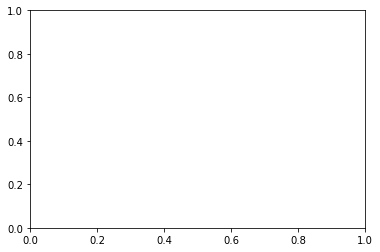

In [15]:
time_array = []
for i in range(1):
    begin = time.time()
    output = net(image.reshape(1,h,w).unsqueeze(0).to(torch.float32))
    cost_out, pred = reg(output, output)
    end = time.time()
    time_array.append(end-begin)
#print(f"Total runtime of the Obelisk Net is {(end - begin)} for one image \nThat means {25*(end - begin)} for 25 images")
plt.scatter(np.arange(1000), time_array)

In [72]:
print("Mean inference time: ", np.asarray(time_array).mean())
print("Variance: ", np.asarray(time_array).var())

Mean inference time:  0.03438071346282959
Variance:  1.955802822584701e-06


Mean infeence time is around 0.034 seconds. Some variance, as seen in the plot. Might be due to background programs

In [17]:
cost_out, pred = reg(output, output)
print(pred.view(grid_size,grid_size,2).shape)
print(cost_out.shape)

torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([32, 32, 2])
torch.Size([1024, 121])


In [8]:
resized = cv2.resize(pred.reshape(grid_size,grid_size,2).detach().numpy(),(h,w))
flow_img = flow2img(resized)

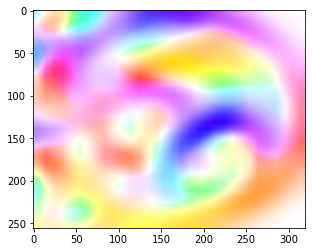

In [9]:
plt.imshow(flow_img)

Obviously this is nonesense, but the flow is there.. not sure about the upscaling though..

In [10]:
# NOT SURE about this cell. If it does any good

segmen_grid = F.grid_sample(segmen.unsqueeze(0).unsqueeze(0),grid_xy+shift_xy,padding_mode='border')
print(segmen_grid.shape)
print(cost_out.view(1,-1,grid_size**2,displacement_width**2).shape)
warped = segmen_grid * cost_out.view(1,-1,grid_size**2,displacement_width**2)
#warped_label = (F.grid_sample(segmen.unsqueeze(0).unsqueeze(0),grid_xy+shift_xy,padding_mode='border') *cost_out.view(1,-1,grid_size**2,displacement_width**2)).sum(3,keepdim=True)

torch.Size([1, 1, 1024, 121])
torch.Size([1, 1, 1024, 121])


## Train the network for 2D Input

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

def augmentAffine(img_in, seg_in, strength=0.05):
    """
    3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: img_in batch (torch.cuda.FloatTensor), seg_in batch (torch.cuda.LongTensor)
    :return: augmented BxCxTxHxW image batch (torch.cuda.FloatTensor), augmented BxTxHxW seg batch (torch.cuda.LongTensor)
    """
    B,C,H,W = img_in.size()
    affine_matrix = (torch.eye(2,3).unsqueeze(0) + torch.randn(B, 2, 3) * strength)#.to(img_in.device)

    meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,H,W)))

    img_out = F.grid_sample(img_in.float(), meshgrid,padding_mode='border')
    seg_out = F.grid_sample(seg_in.float().unsqueeze(1), meshgrid, mode='nearest').long().squeeze(1)

    return img_out, seg_out

In [8]:
torch.manual_seed(10)

pat_indices = torch.cat((torch.arange(0, 17), torch.arange(18, 43)), 0)

rnd_perm_idc = torch.randperm(pat_indices.size(0))
pat_indices = pat_indices[rnd_perm_idc]
# train_set = pat_indices[:35]
# test_set = torch.cat((pat_indices[35:],torch.LongTensor([17])),0)

# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 33, 38, 39, 17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

print('Test_Set:', test_set)
print('Train_Set:', train_set)

Test_Set: tensor([35, 41,  0,  4, 33, 38, 39, 17])
Train_Set: tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 40, 42])


In [14]:
net = OBELISK2d()
net.apply(init_weights)
net.train()

reg = deeds2d()

H, W = img[0].size()

class_weight = torch.sqrt(1.0/(torch.bincount(seg.view(-1)).float()))
class_weight = class_weight/class_weight.mean()
class_weight[0] = 0.15
#class_weight[4] /= 10
print('inv sqrt class_weight',class_weight)
criterion = nn.CrossEntropyLoss(class_weight)

epochs = 1000
optimizer = torch.optim.Adam(list(net.parameters())+list(reg.parameters()),lr=0.0005)
lambda_weight = 1.5#2#2.5#1.5
run_labelloss = torch.zeros(epochs)#/0
run_diffloss = torch.zeros(epochs)

inv sqrt class_weight tensor([0.1500, 0.1535, 0.1800, 0.3199, 7.6096, 0.0681, 0.1290, 0.2074, 0.3098])


<ipython-input-7-7d54f1414354>:3: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
<ipython-input-7-7d54f1414354>:5: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.0)


In [15]:
for i in range(epochs):
    
    idx = train_set[torch.randperm(6)].view(2,3)[:,0]
    
    optimizer.zero_grad()

    label_moving = torch.zeros(size=(1,9,H,W))
    label_moving = label_moving.scatter_(1, seg[idx[1]:idx[1]+1,:,:].type(torch.int64).unsqueeze(1), 1)

    img00_in = img[idx[0]:idx[0]+1,:,:].unsqueeze(0).float() / 255
    img50 = img[idx[1]:idx[1]+1,:,:].unsqueeze(0).float() / 255

    img00, seg50 = augmentAffine(img00_in,seg[idx[0]:idx[0]+1,:,:],0.0375)
    img00.requires_grad = True
    img50.requires_grad = True

    label_fixed = torch.zeros(size=(1,9,H,W))
    label_fixed = label_fixed.scatter_(1, seg50.unsqueeze(1), 1)

    # get features (regular grid)
    feat00 = net(img00)#checkpoint(net,img00)#net(img00)# #00 is fixed
    feat50 = net(img50)#checkpoint(net,img50)#net(img50)# #50 is moving
    # run differentiable deeds (regular grid)
    cost_soft,pred_xy =  reg(feat00,feat50)#checkpoint(reg,feat00,feat50)#reg(feat00,feat50)#
    pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    # evaluate diffusion regularisation loss
    
    diffloss = lambda_weight*((pred_xy[0,:,1:,:]-pred_xy[0,:,:-1,:])**2).mean()+\
            lambda_weight*((pred_xy[0,1:,:,:]-pred_xy[0,:-1,:,:])**2).mean()+\
            lambda_weight*((pred_xy[0,:,:,1:]-pred_xy[0,:,:,:-1])**2).mean()
    run_diffloss[i] = diffloss.item()


    # evaluate non-local loss
    nonlocal_label = (F.grid_sample(label_moving,grid_xy+shift_xy,padding_mode='border')\
                          *cost_soft.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    fixed_label = F.grid_sample(label_fixed,grid_xy,padding_mode='border')#.long().squeeze(1)

    labelloss = ((nonlocal_label-fixed_label)**2)*class_weight.view(1,-1,1,1)
    labelloss = labelloss.mean()
    #labelloss = criterion(nonlocal_label,fixed_label)
    run_labelloss[i] = labelloss.item()
    (labelloss+diffloss).backward()
    
    optimizer.step()
    if(i%50==49):

        loss_avg = F.avg_pool1d(run_labelloss.view(1,1,-1),5,stride=1).squeeze().numpy()[:i]
        print('run_labelloss',loss_avg[-1])
        loss_avg = F.avg_pool1d(run_diffloss.view(1,1,-1),5,stride=1).squeeze().numpy()[:i]
        print('run_diffloss',loss_avg[-1])

run_labelloss 0.006343366
run_diffloss 0.0011852585
run_labelloss 0.0060913004
run_diffloss 0.00038940512
run_labelloss 0.006406896
run_diffloss 0.00019256669
run_labelloss 0.0063156723
run_diffloss 0.00016666915
run_labelloss 0.0063293697
run_diffloss 0.00014585328
run_labelloss 0.006331064
run_diffloss 8.346299e-05
run_labelloss 0.0060716416
run_diffloss 8.4626474e-05
run_labelloss 0.006085858
run_diffloss 8.495875e-05
run_labelloss 0.0062939166
run_diffloss 4.952103e-05
run_labelloss 0.0060563236
run_diffloss 4.5558903e-05
run_labelloss nan
run_diffloss nan
run_labelloss nan
run_diffloss nan
run_labelloss nan
run_diffloss nan
run_labelloss nan
run_diffloss nan
run_labelloss nan
run_diffloss nan
run_labelloss nan
run_diffloss nan


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(epochs), run_diffloss)

In [ ]:
plt.plot(np.arange(epochs), run_labelloss)

In [15]:
random_test = test_set[torch.randperm(6)].view(2,3)[:,0]
test_img_1 = img[random_test[0]:random_test[0]+1,:,:].unsqueeze(0).float() / 255
test_img_2 = img[random_test[1]:random_test[1]+1,:,:].unsqueeze(0).float() / 255

label_1= seg[random_test[0]:random_test[0]+1,:,:]
label_2= seg[random_test[1]:random_test[1]+1,:,:]
label_2.view(h,w,-1).shape

torch.Size([320, 256, 1])

In [16]:
fixed = net(test_img_1)
moving = net(test_img_2)

test_cost_xy, test_pred_xy = reg(fixed,moving) 

In [17]:
test_pred_xy = test_pred_xy.view(1,grid_size,grid_size,2)

In [18]:
#resized = cv2.resize(test_pred_xy.reshape(grid_size,grid_size,2).detach().numpy(),(w,h))
resized = F.interpolate(test_pred_xy,scale_factor=4,mode='bicubic')
flow_img = flow2img(resized)

In [19]:
resized.shape

(320, 256, 2)

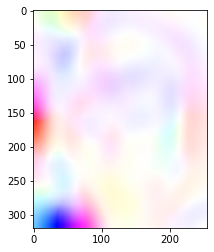

In [20]:
plt.imshow(flow_img)

In [21]:
resized = torch.from_numpy(resized).reshape(2,h,w)
resized.shape

torch.Size([2, 320, 256])

In [22]:
target = label_2.view(1,1,h,w).float()
target.shape

torch.Size([1, 1, 320, 256])

In [23]:
warped_seg_2 = warp(target.cuda(), resized.cuda()).cpu()

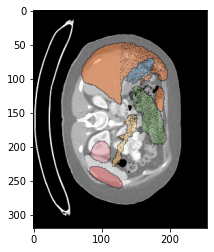

In [24]:
plt.imshow(overlaySegment(test_img_1.squeeze(),warped_seg_2.squeeze() ,False).numpy())

# Exploration 20.05
try to figure out how to upscale the pred_xy from the network

In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import cv2
from math import ceil
import matplotlib.pyplot as plt

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet
from utils.plotting import flow2img

from models.pdd_net.pdd_student import OBELISK2d, deeds2d

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [2]:
net = OBELISK2d()
reg = deeds2d()

In [3]:
img = torch.load("Data/img.pth")/255
segs = torch.load("Data/seg.pth")

In [57]:
fix = 10; mov = 11
fixed = img[fix:fix+1,:,:] / 255
moving = img[mov:mov+1,:,:] / 255

segs_fixed = segs[fix:fix+1,:,:]
segs_moving = segs[mov:mov+1,:,:]

In [89]:
fixed.shape

torch.Size([1, 320, 256])

In [91]:
inter = F.interpolate(fixed.unsqueeze(0), size=(120,120))

In [92]:
inter.shape

torch.Size([1, 1, 120, 120])

In [95]:
feat00 = net(F.interpolate(fixed.unsqueeze(0), size=(120,120)))
feat50 = net(F.interpolate(moving.unsqueeze(0), size=(120,120)))

cost_soft, pred_xy = reg(feat00,feat50)

In [96]:
cost_soft.shape

torch.Size([1024, 121])

In [97]:
pred_xy.shape

torch.Size([1024, 2])

In [98]:
grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

disp_range = 0.25#0.25
displacement_width = 11#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [99]:
test = (F.grid_sample(seg_moving,grid_xy+shift_xy,padding_mode='border')\
                          *cost_soft.view(1,-1,32**2,11**2,1)).sum()

RuntimeError: The size of tensor a (1024) must match the size of tensor b (121) at non-singleton dimension 3

In [100]:
seg_moving.shape

torch.Size([1, 8, 320, 256])

In [101]:
a = grid_xy+shift_xy
a.shape

torch.Size([1, 1024, 121, 2])

In [69]:
test1 = F.grid_sample(seg_moving,grid_xy+shift_xy,padding_mode='border')

In [70]:
test1.shape

torch.Size([1, 8, 1024, 121])

In [75]:
test2 = (test1* cost_soft).squeeze()

In [76]:
test2.shape

torch.Size([8, 1024, 121])

In [102]:
test2.view(8,120,-1).shape

RuntimeError: shape '[8, 120, -1]' is invalid for input of size 991232

## Exploration 27.05
explore 3D version

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [20]:
imgs = torch.load("Data/img.pth")
H,W,D = imgs.shape

o_m = H//3
o_n = W//3
o_o = D//3
#print('numel_o',o_m*o_n*o_o)
ogrid_xyz = F.affine_grid(torch.eye(3,4).unsqueeze(0),(1,1,o_m,o_n,o_o)).view(1,1,-1,1,3)


class OBELISK(nn.Module):
    def __init__(self):

        super(OBELISK, self).__init__()
        channels = 24#16
        self.offsets = nn.Parameter(torch.randn(2,channels*2,3)*0.05)
        self.layer0 = nn.Conv3d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm3d(4)

        self.layer1 = nn.Conv3d(channels*8, channels*4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm3d(channels*4)
        self.layer2 = nn.Conv3d(channels*4, channels*4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm3d(channels*4)
        self.layer3 = nn.Conv3d(channels*4, channels*1, 1)


    def forward(self, input_img):
        img_in = F.avg_pool3d(input_img,3,padding=1,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in,ogrid_xyz + self.offsets[0,:,:].view(1,-1,1,1,3)).view(1,-1,o_m,o_n,o_o)
        sampled -= F.grid_sample(img_in,ogrid_xyz + self.offsets[1,:,:].view(1,-1,1,1,3)).view(1,-1,o_m,o_n,o_o)
    
        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features




disp_range = 0.4#0.25
displacement_width = 15#11#17
shift_xyz = F.affine_grid(disp_range*torch.eye(3,4).unsqueeze(0),(1,1,displacement_width,displacement_width,displacement_width)).view(1,1,-1,1,3)#.cuda()

grid_size = 32#25#30
grid_xyz = F.affine_grid(torch.eye(3,4).unsqueeze(0),(1,1,grid_size,grid_size,grid_size)).view(1,-1,1,1,3)#.cuda()

class deeds(nn.Module):
    def __init__(self):

        super(deeds, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1,.1,1,1,.1,1]))#.cuda()

        self.pad1 = nn.ReplicationPad3d(3)#.cuda()
        self.avg1 = nn.AvgPool3d(3,stride=1)#.cuda()
        self.max1 = nn.MaxPool3d(3,stride=1)#.cuda()
        self.pad2 = nn.ReplicationPad3d(2)#.cuda()##



    def forward(self, feat00,feat50):
        
        #deeds correlation layer (slightly unrolled)
        deeds_cost = torch.zeros(1,grid_size**3,displacement_width,displacement_width,displacement_width)#.cuda()
        xyz8 = grid_size**2
        for i in range(grid_size): 
            moving_unfold = F.grid_sample(feat50,grid_xyz[:,i*xyz8:(i+1)*xyz8,:,:,:] + shift_xyz,padding_mode='border')
            fixed_grid = F.grid_sample(feat00,grid_xyz[:,i*xyz8:(i+1)*xyz8,:,:,:])
            deeds_cost[:,i*xyz8:(i+1)*xyz8,:,:,:] = self.alpha[1]+self.alpha[0]*torch.sum(torch.pow(fixed_grid-moving_unfold,2),1).view(1,-1,displacement_width,displacement_width,displacement_width)

        # remove mean (not really necessary)
        #deeds_cost = deeds_cost.view(-1,displacement_width**3) - deeds_cost.view(-1,displacement_width**3).mean(1,keepdim=True)[0]
        deeds_cost = deeds_cost.view(1,-1,displacement_width,displacement_width,displacement_width)
    
        # approximate min convolution / displacement compatibility
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(deeds_cost))))
   
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,4,0,1).view(1,displacement_width**3,grid_size,grid_size,grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,4,1).view(1,-1,displacement_width,displacement_width,displacement_width)
        
        # second path
        cost = self.alpha[4]+self.alpha[2]*deeds_cost+self.alpha[3]*cost_avg
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(cost))))
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,4,0,1).view(1,displacement_width**3,grid_size,grid_size,grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,4,1).view(grid_size**3,displacement_width**3)
        #cost = alpha[4]+alpha[2]*deeds_cost+alpha[3]*cost.view(1,-1,displacement_width,displacement_width,displacement_width)
        #cost = avg1(avg1(-max1(-pad1(cost))))
        
        #probabilistic and continuous output
        cost_soft = F.softmax(-self.alpha[5]*cost_avg,1)
#        pred_xyz = torch.sum(F.softmax(-5self.alpha[2]*cost_avg,1).unsqueeze(2)*shift_xyz.view(1,-1,3),1)
        pred_xyz = torch.sum(cost_soft.unsqueeze(2)*shift_xyz.view(1,-1,3),1)



        return cost_soft,pred_xyz

In [21]:
net = OBELISK()
reg = deeds()

In [22]:
net_weights = torch.load("models/pdd_net/dense_reg_feat_v01.pth")
net_weights.keys()

odict_keys(['offsets', 'layer0.weight', 'batch0.weight', 'batch0.bias', 'batch0.running_mean', 'batch0.running_var', 'batch0.num_batches_tracked', 'layer1.weight', 'batch1.weight', 'batch1.bias', 'batch1.running_mean', 'batch1.running_var', 'batch1.num_batches_tracked', 'layer2.weight', 'batch2.weight', 'batch2.bias', 'batch2.running_mean', 'batch2.running_var', 'batch2.num_batches_tracked', 'layer3.weight', 'layer3.bias'])

In [23]:
net.load_state_dict(net_weights)

RuntimeError: Error(s) in loading state_dict for OBELISK:
	size mismatch for layer1.weight: copying a param with shape torch.Size([48, 48, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 192, 1, 1, 1]).
	size mismatch for batch1.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch1.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch1.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for layer2.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3, 3]).
	size mismatch for batch2.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch2.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch2.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for layer3.weight: copying a param with shape torch.Size([24, 48, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 96, 1, 1, 1]).